In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np

In [4]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import *
from keras.constraints import UnitNorm

from keras.datasets import fashion_mnist, mnist

Using TensorFlow backend.


In [5]:
from gradient_reversal_keras_tf.gradient_reversal_layer import GradientReversal
from utils import *

# Loading and preparing data

In [15]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [16]:
x_train = x_train.reshape((x_train.shape[0], -1)).astype(np.float32)
x_test = x_test.reshape((x_test.shape[0], -1)).astype(np.float32)

# x_train = x_train[y_train < 2]
# x_test = x_test[y_test < 2]
# y_test = y_test[y_test < 2]

x_train = x_train / 255.
x_test = x_test / 255.

n_classes = len(set(y_train))

In [17]:
BATCH_SIZE = 32
N_EPOCH = 16

INPUT_DIM = x_train.shape[1]
LATENT_DIM = 2
HIDDEN_DIM = 256

# Simple VAE

<br>During experimets I found that `LATENT_DIM == 2` is not sufficent for appropriate quality of didgits reconstruction: in that case decoder just ignored it's inputs due to lack of informativity. There is two solutions: pick right loss weights or increase capacity of latent vecor (>=64). First solution tends KL divergence to be huge, second solution makes visualization impossible without any dimension reduction techniques (such as PCA or tSNE). <br> I adjusted loss weights: now AE is able to recover digits, but posterior distribution is slightly distant from desired prior.

### Definition and training

In [18]:
# Encoder
inp_e = Input((INPUT_DIM,))
e = Dense(HIDDEN_DIM, activation='relu')(inp_e)
e = Dense(HIDDEN_DIM, activation='relu')(e)

# Reparametrization trick
z_mean = Dense(LATENT_DIM)(e)
z_log_sigma = Dense(LATENT_DIM)(e)
z_code = Lambda(lambda x: x[0] + K.exp(x[1]) * K.random_normal(shape=K.shape(x[0])))([z_mean, z_log_sigma])
           
encoder = Model(inp_e, [z_code, z_mean, z_log_sigma], name='encoder')

# Decoder
inp_d = Input((LATENT_DIM,))
d = Dense(HIDDEN_DIM, activation='relu')(inp_d)
d = Dense(HIDDEN_DIM, activation='relu')(d)
d = Dense(INPUT_DIM, activation='sigmoid')(d)

decoder = Model(inp_d, d, name='decoder')

# Stacking all together
inp_x = Input((INPUT_DIM,))

z_code, z_mean, z_log_sigma = encoder(inp_x)
reconstruction = decoder(z_code)
kl_divergence = Lambda(lambda x: -0.5 * K.mean(1 + x[1] - K.square(x[0]) - K.exp(x[1]), axis=-1), name='KLD')([z_mean, z_log_sigma])

trainable = Model(inp_x, [reconstruction, kl_divergence])
trainable.compile('rmsprop', ['binary_crossentropy', lambda y_true, y_pred: y_pred], loss_weights=[INPUT_DIM, LATENT_DIM])
# trainable.summary()

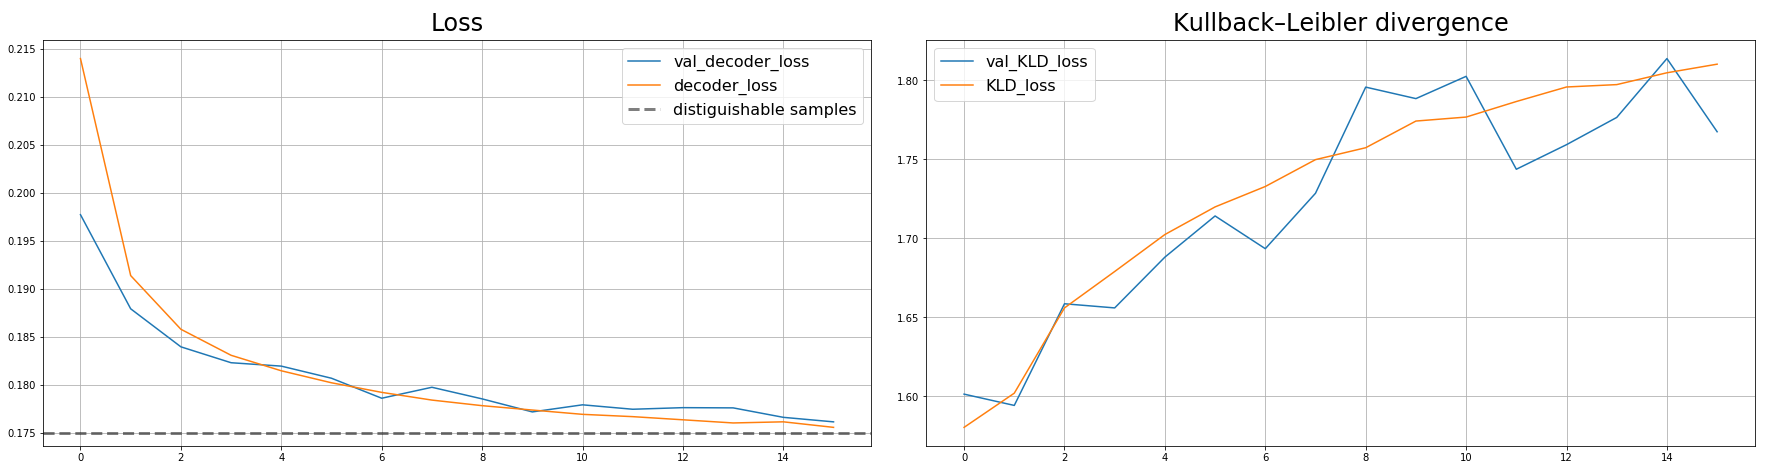

In [19]:
trainable.fit(x=x_train, y=[x_train, np.zeros(x_train.shape[0])], batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=0, 
              validation_data=(x_test, [x_test, np.zeros(x_test.shape[0])]), shuffle=True,
              callbacks=[VisualizeTraining(({'text':'Loss', 'loss_signature':'decoder', 'constants':{'distiguishable samples': 0.175}}, 
                                            {'text':'Kullback–Leibler divergence', 'loss_signature':'KLD', 'constants':{}}))],)

### Results

In [20]:
z_space_code, z_mean_test, z_log_sigma_test = encoder.predict(x_test)
z1, z2 = z_space_code.T

<br>Statistics of latent dimension ...

In [21]:
z_space_code.mean(), z_space_code.std()

(-0.07198684, 0.9013841)

<br>Parameters of standard normal ...

In [22]:
z_mean_test.mean(), z_mean_test.std()

(-0.07093253, 0.9017146)

In [23]:
np.exp(z_log_sigma_test).mean(), np.exp(z_log_sigma_test).std()

(0.032559555, 0.034368362)

<br>Kullback–Leibler divergence ...

In [24]:
np.mean(-0.5 * np.mean(1 + z_log_sigma_test - np.square(z_mean_test) - np.exp(z_log_sigma_test), axis=-1))

1.7674536

In [27]:
n_points = 20
z_space_range = (-1, 1)
z_values_range = np.arange(z_space_range[0], z_space_range[1], (z_space_range[1] - z_space_range[0]) / n_points)
z_space_grid = np.array([(z1, z2) for z1 in z_values_range for z2 in z_values_range[::-1]])
z_space_image = decoder.predict(z_space_grid).reshape((n_points, n_points, 28, 28)) / 255.
z_space_image = np.concatenate(z_space_image, axis=-1)
z_space_image = np.concatenate(z_space_image, axis=0)

In [28]:
# n_points = 20
# samples = np.zeros((n_points * n_classes, INPUT_DIM))
# for i in set(y_test):
#     x_test_i = x_test[y_test == i]
#     samples[i*n_points:(i+1)*n_points] = x_test_i[np.random.randint(x_test_i.shape[0], size=n_points)]
    
# reonstructed_samples = trainable.predict(samples)[0]
# z_space_image = reonstructed_samples.reshape((n_classes, n_points, 28, 28))
# z_space_image = np.concatenate(z_space_image, axis=-1)
# z_space_image = np.concatenate(z_space_image, axis=0)

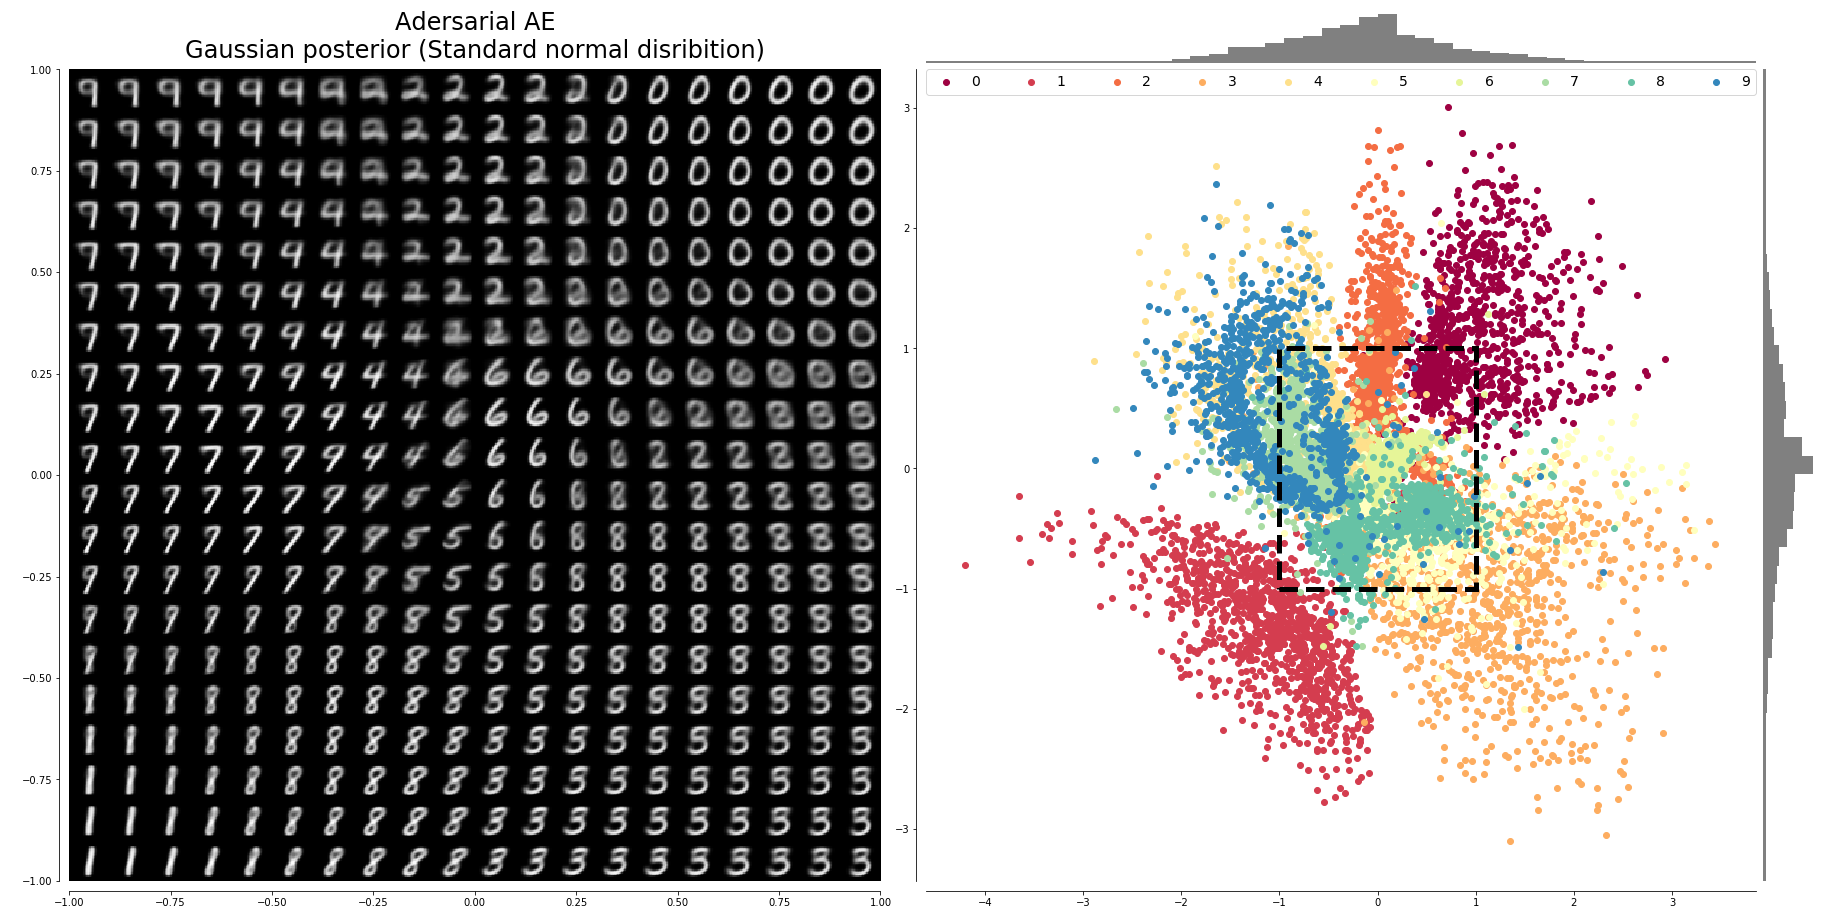

In [29]:
visualize('Adersarial AE\nGaussian posterior (Standard normal disribition)', z_space_image, (-1, 1), z1, z2, y_test)

# Adversarial VAE

In [35]:
LATENT_DIM = 64

### Definition and training

In [36]:
# Encoder
inp_encoder_x = Input((INPUT_DIM,))
inp_encoder_noise = Input((LATENT_DIM,))
e = concatenate([inp_encoder_x, inp_encoder_noise])

e = Dense(HIDDEN_DIM, activation='relu')(e)
e = Dense(HIDDEN_DIM, activation='relu')(e)
e = Dense(LATENT_DIM, activation='linear')(e)

encoder = Model([inp_encoder_x, inp_encoder_noise], e, name='encoder')

# Decoder
inp_d = Input((LATENT_DIM,))
d = Dense(HIDDEN_DIM, activation='relu')(inp_d)
d = Dense(HIDDEN_DIM, activation='relu')(d)
d = Dense(INPUT_DIM, activation='sigmoid')(d)

decoder = Model(inp_d, d, name='decoder')

# Discriminator
inp_discriminator_x = Input((INPUT_DIM,))
inp_discriminator_z = Input((LATENT_DIM,))
a = concatenate([inp_discriminator_x, inp_discriminator_z])
a = GradientReversal()(a)
a = Dense(HIDDEN_DIM, activation='relu')(a)
a = Dense(HIDDEN_DIM, activation='relu')(a)
a = Dense(1, activation='sigmoid')(a)

discriminator = Model([inp_discriminator_x, inp_discriminator_z], a, name='discriminator')

# Stacking all together
inp_x = Input((INPUT_DIM,))
inp_noise = Input((LATENT_DIM,))
prior_distribution = Input((LATENT_DIM,))

reconstruction = decoder(encoder([inp_x, inp_noise]))
discriminator_fake = Lambda(lambda x: x, name='discriminator_fake')(discriminator([inp_x, encoder([inp_x, inp_noise])]))
discriminator_real = Lambda(lambda x: x, name='discriminator_real')(discriminator([inp_x, prior_distribution]))

trainable = Model([inp_x, inp_noise, prior_distribution], [reconstruction, discriminator_fake, discriminator_real])
trainable.compile('rmsprop', 'binary_crossentropy')#, loss_weights=[INPUT_DIM // len(set(y_train)), LATENT_DIM, LATENT_DIM])
# trainable.summary()

In [37]:
def batch_generator(data, batch_size):
    n_steps = len(data) // batch_size
    ones = np.ones(batch_size)
    zeros = np.zeros(batch_size)
    
    def generator():
        while True:
            np.random.shuffle(data)
            for i in range(n_steps):
                X = data[i*batch_size:(i+1)*batch_size]
                input_noise = np.random.uniform(size=(batch_size, LATENT_DIM))
                prior_noise = np.random.standard_normal((batch_size, LATENT_DIM))
                
                yield [X, input_noise, prior_noise], [X, zeros, ones]
                
    return generator(), n_steps

In [38]:
train_gen, train_steps = batch_generator(x_train, BATCH_SIZE)
test_gen, test_steps = batch_generator(x_train, BATCH_SIZE)

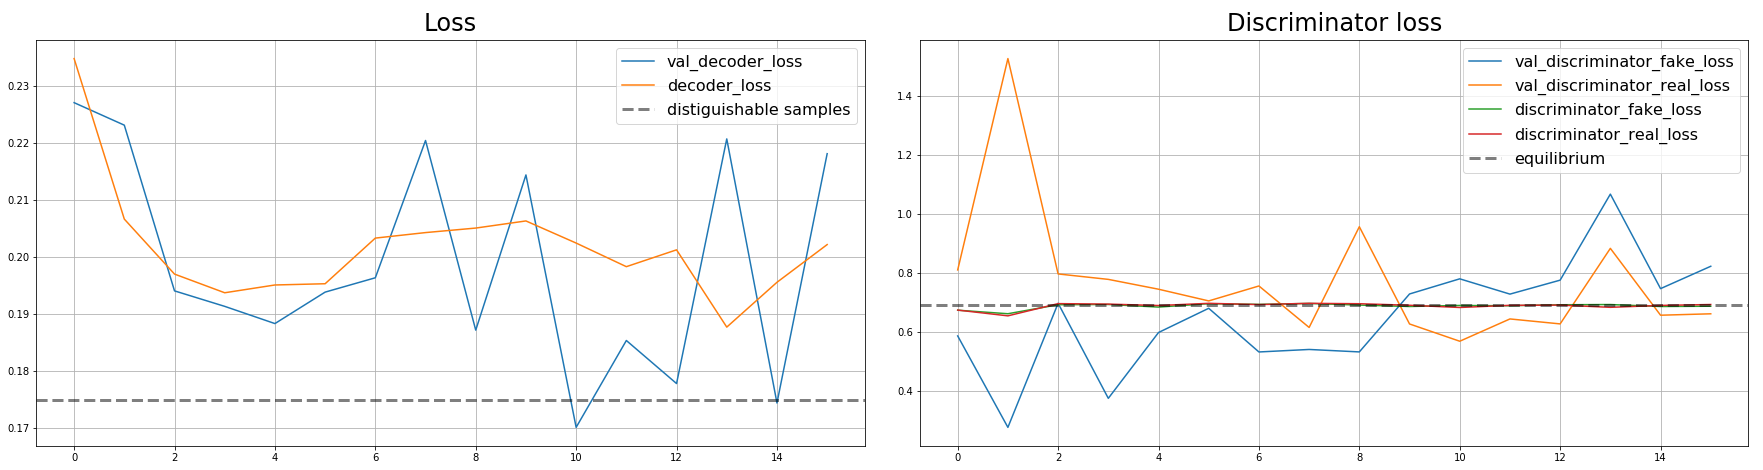

In [39]:
trainable.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=N_EPOCH, verbose=0, 
                    callbacks=[VisualizeTraining(({'text':'Loss', 'loss_signature':'decoder', 'constants':{'distiguishable samples': 0.175}}, 
                                                  {'text':'Discriminator loss', 'loss_signature':'discriminator', 'constants':{'equilibrium': -np.log(0.5)}}))],
                    validation_data=test_gen, validation_steps=test_steps, 
                    max_queue_size=10, workers=1, use_multiprocessing=False)

### Results

In [177]:
z_space_code = encoder.predict([x_test, np.random.standard_normal((x_test.shape[0], LATENT_DIM))])
# z1, z2 = z_space_code.T

<br>Statistics...

In [178]:
z_space_code.mean(), z_space_code.std()

(-0.01592254, 1.6132132)

In [170]:
n_points = 20
z_space_range = (-1, 1)
z_values_range = np.arange(z_space_range[0], z_space_range[1], (z_space_range[1] - z_space_range[0]) / n_points)
z_space_grid = np.array([(z1, z_space_range[1] - z2) for z1 in z_values_range for z2 in z_values_range])
z_space_image = decoder.predict(z_space_grid).reshape((n_points, n_points, 28, 28))
z_space_image = np.concatenate(z_space_image, axis=-1)
z_space_image = np.concatenate(z_space_image, axis=0)

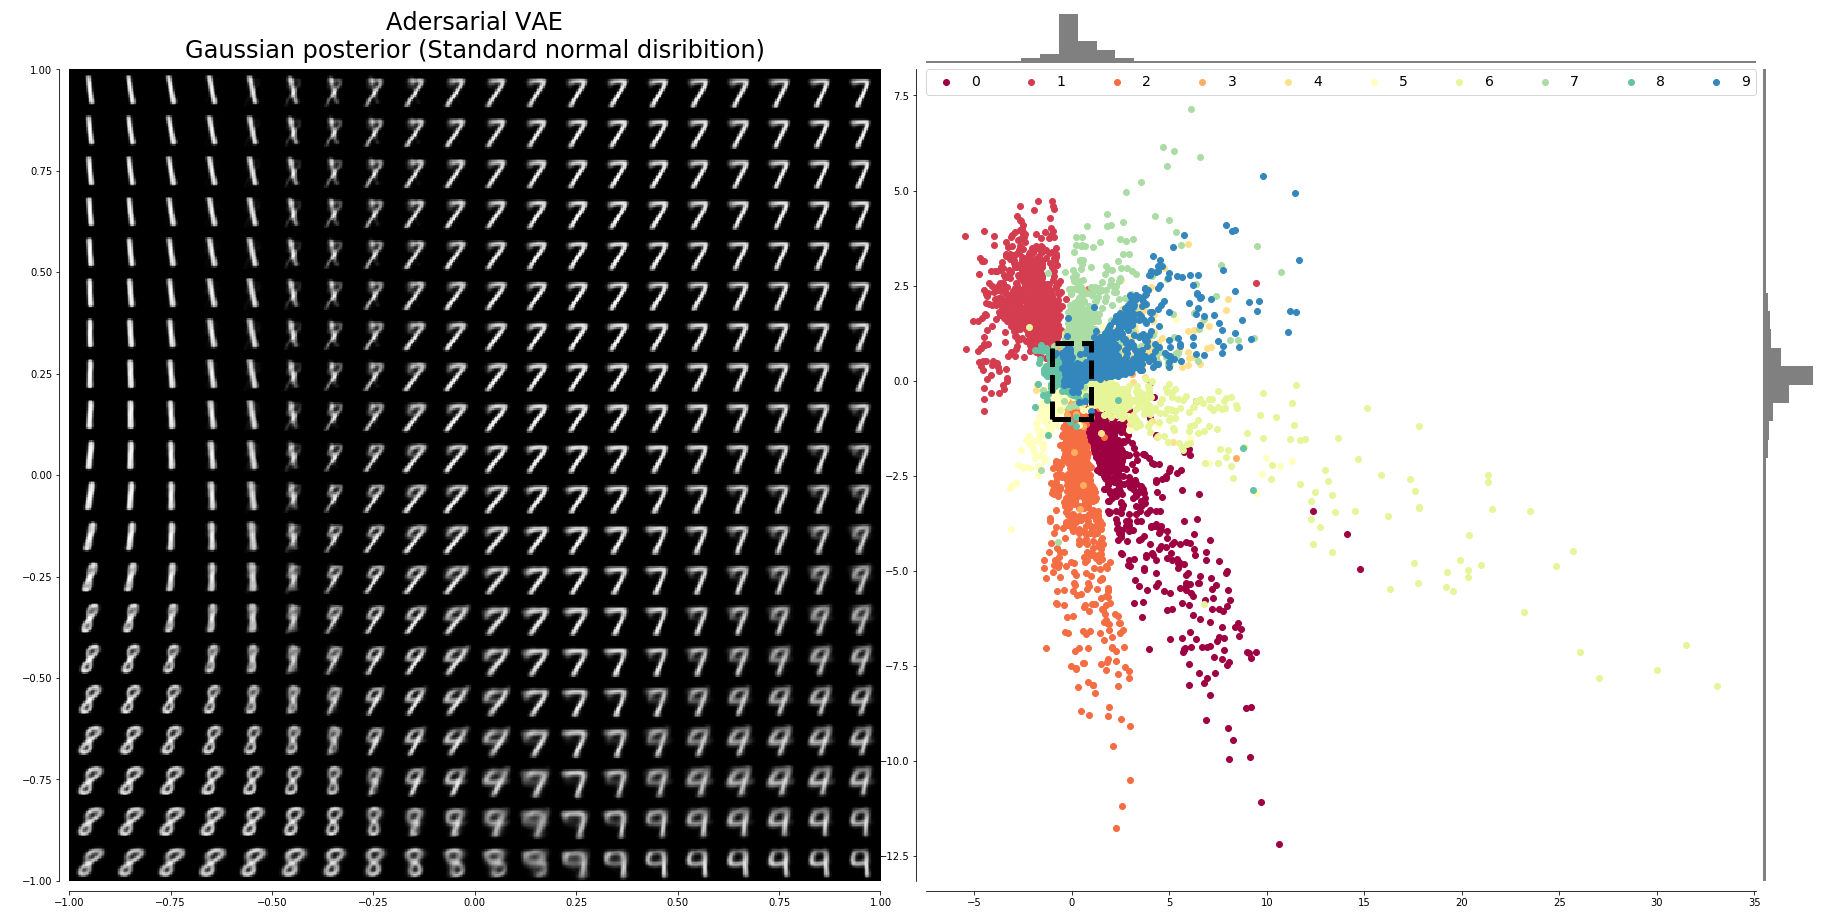

In [171]:
visualize('Adersarial VAE\nGaussian posterior (Standard normal disribition)', z_space_image, z_space_range, z1, z2, y_test)

# Adversarial VAE with Adaptive Contrast

In [73]:
N_SAMPLES = 64

### Definition and training

In [155]:
# Encoder
inp_encoder_x = Input((INPUT_DIM,))
inp_encoder_noise = Input((LATENT_DIM,))
e = concatenate([inp_encoder_x, inp_encoder_noise])

e = Dense(HIDDEN_DIM, activation='relu')(e)
e = Dense(HIDDEN_DIM, activation='relu')(e)
e = Dense(LATENT_DIM, activation='linear')(e)

encoder = Model([inp_encoder_x, inp_encoder_noise], e, name='encoder')
encoder._make_predict_function()

# Decoder
inp_d = Input((LATENT_DIM,))
d = Dense(HIDDEN_DIM, activation='relu')(inp_d)
d = Dense(HIDDEN_DIM, activation='relu')(d)
d = Dense(INPUT_DIM, activation='sigmoid')(d)

decoder = Model(inp_d, d, name='decoder')

# Discriminator
inp_discriminator_x = Input((INPUT_DIM,))
inp_discriminator_z = Input((LATENT_DIM,))
a = concatenate([inp_discriminator_x, inp_discriminator_z])
a = GradientReversal()(a)
a = Dense(HIDDEN_DIM, activation='relu')(a)
a = Dense(HIDDEN_DIM, activation='relu')(a)

a = Dense(1, activation='sigmoid')(a)

discriminator = Model([inp_discriminator_x, inp_discriminator_z], a, name='discriminator')

# Stacking all together
inp_x = Input((INPUT_DIM,), name='data')
inp_noise = Input((LATENT_DIM,), name='noise')
       
# q-statistics
posterior_mean = Input((LATENT_DIM,), name='posterior_mean')
posterior_std = Input((LATENT_DIM,), name='posterior_std')
                  
prior_samples = Input((LATENT_DIM,), name='prior')

posterior_samples = encoder([inp_x, inp_noise])
# def get_adaptive_prior(x):
#     mean = K.mean(x, axis=0)
#     std = K.std(x, axis=0)
    
#     prior_components = []
#     for i in range(LATENT_DIM):
#         prior_components.append(K.random_normal(shape=(BATCH_SIZE, 1), mean=mean[i], stddev=std[i]))
    
#     return K.stop_gradient(K.concatenate(prior_components))

# adaptive_prior = Lambda(get_adaptive_prior, name='adaptive_prior')(posterior_samples)

def normalize_posterior(x):
    x, mean, std = x
    mean = K.mean(mean, axis=0)
    std = K.std(std, axis=0)
    
    return (x - mean) / std

posterior_samples_ = Lambda(normalize_posterior, name='normalized_posterior')([posterior_samples, posterior_mean, posterior_std])

reconstruction = decoder(posterior_samples)
discriminator_fake = Lambda(lambda x: x, name='discriminator_fake')(discriminator([inp_x, posterior_samples_]))
discriminator_real = Lambda(lambda x: x, name='discriminator_real')(discriminator([inp_x, prior_samples]))

trainable = Model([inp_x, inp_noise, prior_samples, posterior_mean, posterior_std], [reconstruction, discriminator_fake, discriminator_real])
trainable.compile('rmsprop', 'binary_crossentropy')
# trainable.summary()

In [156]:
def batch_generator(data, batch_size):
    n_steps = len(data) // batch_size
    ones = np.ones(batch_size)
    zeros = np.zeros(batch_size)
    
    def generator():
        while True:
            np.random.shuffle(data)
            for i in range(n_steps):
                X = data[i*batch_size:(i+1)*batch_size]
                input_noise = np.random.uniform(size=(batch_size, LATENT_DIM))
                prior_samples = np.random.standard_normal(size=(batch_size, LATENT_DIM))
                
#                 adaptive_prior = []
#                 for x in X:
#                     x = x * np.ones((N_SAMPLES, x.shape[-1]))
#                     z = encoder.predict([x, np.random.uniform(size=(N_SAMPLES, LATENT_DIM))])
#                     adaptive_prior.append(np.random.normal(loc=z.mean(axis=0), scale=z.std(axis=0)))
#                 adaptive_prior = np.vstack(adaptive_prior)

                posterior_samples = encoder.predict([np.repeat(X, N_SAMPLES, axis=0), np.random.uniform(size=(BATCH_SIZE * N_SAMPLES, LATENT_DIM))])
                posterior_samples = posterior_samples.reshape(BATCH_SIZE, N_SAMPLES, LATENT_DIM)
                posterior_mean = posterior_samples.mean(axis=1)
                posterior_std = posterior_samples.std(axis=1)
                
                yield [X, input_noise, prior_samples, posterior_mean, posterior_std], [X, zeros, ones]
                
    return generator(), n_steps

In [157]:
train_gen, train_steps = batch_generator(x_train, BATCH_SIZE)
test_gen, test_steps = batch_generator(x_train, BATCH_SIZE)

In [158]:
[X, input_noise, prior_samples, posterior_mean, posterior_std], *_ = next(train_gen)
posterior_std.shape

(32, 128)

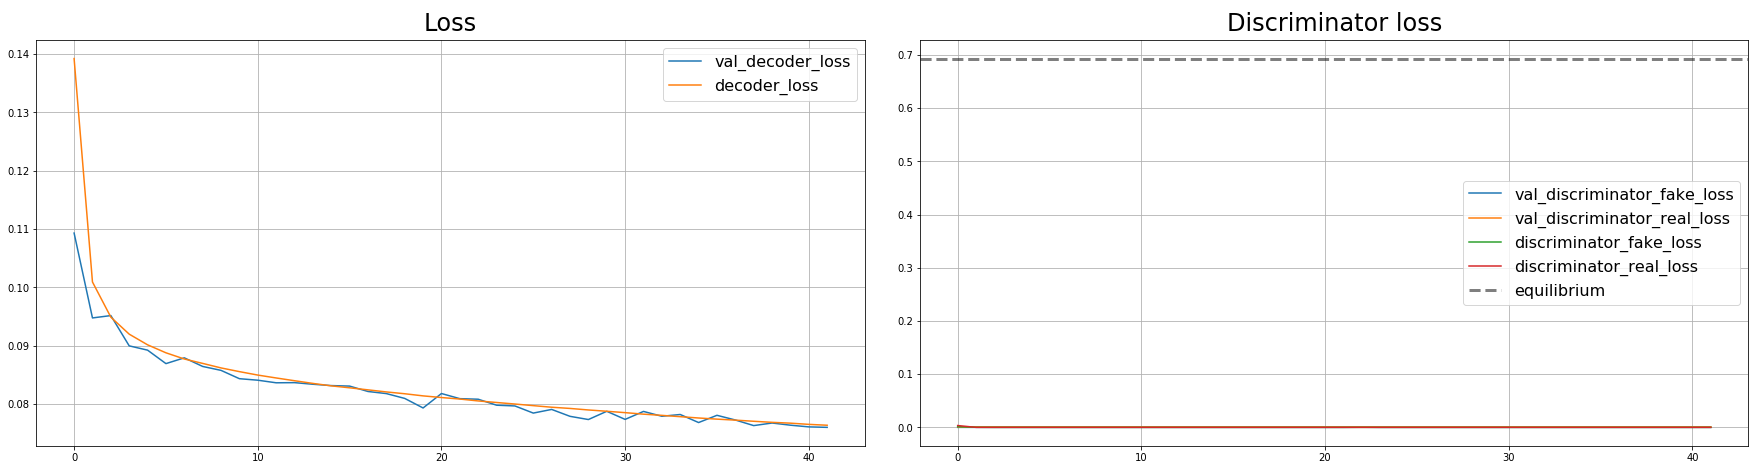

KeyboardInterrupt: 

In [159]:
trainable.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=N_EPOCH, verbose=0, 
                    callbacks=[VisualizeTraining(({'text':'Loss', 'loss_signature':'decoder', 'constants':{}}, 
                                                  {'text':'Discriminator loss', 'loss_signature':'discriminator', 'constants':{'equilibrium': -np.log(0.5)}}))],
                    validation_data=test_gen, validation_steps=test_steps, 
                    max_queue_size=10, workers=1, use_multiprocessing=False)

### Results

In [ ]:
n_points = 20
z_space_range = (-1, 1)
z_values_range = np.arange(z_space_range[0], z_space_range[1], (z_space_range[1] - z_space_range[0]) / n_points)
z_space_grid = np.array([(z1, z_space_range[1] - z2) for z1 in z_values_range for z2 in z_values_range])
z_space_image = decoder.predict(z_space_grid).reshape((n_points, n_points, 28, 28))
z_space_image = np.concatenate(z_space_image, axis=-1)
z_space_image = np.concatenate(z_space_image, axis=0)

In [160]:
z_space_code = encoder.predict([x_test, np.random.standard_normal((x_test.shape[0], LATENT_DIM))])
# z1, z2 = z_space_code.T

<br>Statistics...

In [161]:
z_space_code.mean(), z_space_code.std()

(-0.026707163, 0.9896084)

In [ ]:
visualize('Adersarial VAE\nGaussian posterior (Standard normal disribition)', z_space_image, z_space_range, z1, z2, y_test)